In [47]:
# read IGES file
# filename = '../data/Tetra_7431_python.vtu'
# outname  = '../data/Tetra_7431_python_solved.vtk'
filename = '../data/FEM/FEM2.vtu'
outname  = '../data/FEM/FEM2_solved.vtu'

In [48]:
import numpy as np
import pyvista as pv
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from matplotlib import pyplot as plt

young = 20e9
poisson = 0.3

mesh = pv.read(filename)
points = mesh.points
tetras = mesh.cells.reshape(-1, 5)[:, 1:]

femesh = MeshTet(points.T, tetras.T)

e1 = ElementTetP1()
e = ElementVector(e1)
ib = Basis(femesh, e, MappingIsoparametric(femesh, e1), 3)

K = asm(linear_elasticity(*lame_parameters(young, poisson)), ib)

deg_xy = lambda x: np.rad2deg(np.arctan2(x[0], x[1]))

dofs = {
    'left' : ib.get_dofs(lambda x: deg_xy(x) < -29.99),
    'right' : ib.get_dofs(lambda x: deg_xy(x) > 29.99),
}

u = ib.zeros()
u[dofs['left'].nodal['u^1']] = -1e-4
u[dofs['right'].nodal['u^1']] = 1e-4

print_udofs = lambda key: print(key, dofs[key].nodal['u^1'].shape)

print_udofs('left')
print_udofs('right')

I = ib.complement_dofs(dofs)

u = solve(*condense(K, x=u, I=I))

sf = 1.0
femesh = femesh.translated(sf * u[ib.nodal_dofs])

print('Writing to', outname)
femesh.save(outname)


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


left (251,)
right (236,)
Writing to ../data/FEM/FEM2_solved.vtu


In [49]:
F = (K @ u).reshape(-1, 3)
F.sum(axis=0)

array([3.17701421e-12, 2.73450707e-12, 5.31452660e-12])

In [50]:
F_left = F[points[:, 0] < 0]
F_right = F[points[:, 0] > 0]

print('Left force:', F_left.sum(axis=0))
print('Right force:', F_right.sum(axis=0))

Left force: [-1.82956540e+02 -3.11474887e-03 -2.66453048e-03]
Right force: [1.82956540e+02 3.11474887e-03 2.66453049e-03]


In [51]:
F_expect = 2e2
scale = F_expect / F_right.sum(axis=0)[0]

u = scale * u

In [52]:
V = points
dV = u.reshape(-1, 3)
T = femesh.t.T

V.shape, dV.shape, T.shape

((9086, 3), (9086, 3), (46366, 4))

In [53]:
(V + dV)[:4]  - femesh.p.T[:4]

pyvista_ndarray([[ 9.59278025e-06,  3.79475443e-07, -1.50596470e-07],
                 [ 9.51959682e-06,  3.24822549e-07, -1.73409309e-07],
                 [ 9.47918895e-06,  2.04856784e-07, -9.18328085e-08],
                 [ 9.64058642e-06,  3.04993070e-07, -1.95097867e-08]])

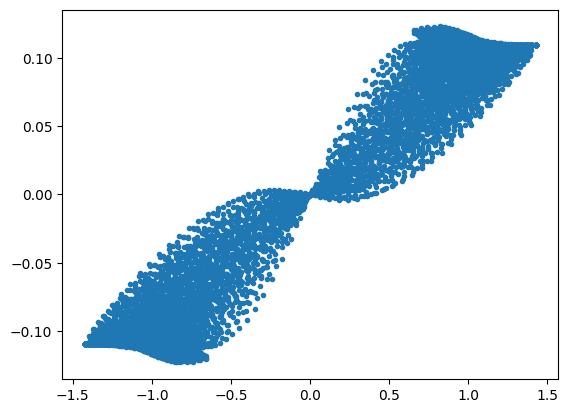

In [54]:
plt.plot(V[:, 0]*1e3, dV[:, 0]*1e3, '.')

## ミーゼス応力の計算

In [55]:
V = V * 1e3
dV = dV * 1e3


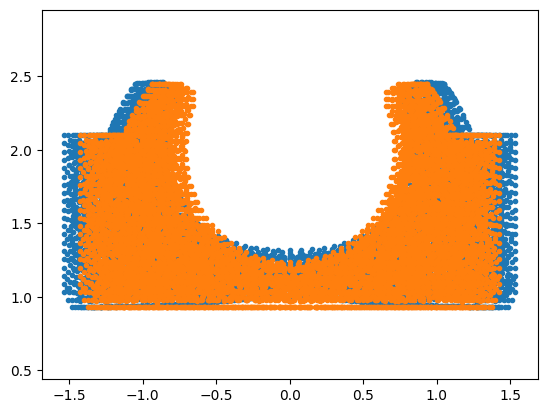

In [56]:
plt.plot(V.T[0] + dV.T[0], V.T[2] + dV.T[2], '.')
plt.plot(V.T[0], V.T[2], '.')

plt.axis('equal')
plt.show()


In [57]:
tetra_coords = lambda v: (v[1:] - v[0]).T

E = np.zeros((T.shape[0], 3, 3))
F = np.zeros((T.shape[0], 3, 3))

for t, i in zip(T, range(T.shape[0])):
    
    # 初期と変位後の座標を計算
    X = tetra_coords(V[t])
    Y = tetra_coords(V[t] + dV[t])
    
    # 変形勾配テンソルFを計算
    F[i] = np.linalg.solve(X.T, Y.T).T
    
    # 右ひずみテンソルEを計算
    E[i] = 0.5 * (F[i].T @ F[i] - np.eye(3))


In [58]:
F[10000], E[10000]

(array([[ 1.01477647, -0.05246314,  0.00970957],
        [ 0.06351322,  0.98521768,  0.00252432],
        [-0.02254451,  0.00367995,  1.00007309]]),
 array([[ 0.01715673,  0.00462651, -0.0062664 ],
        [ 0.00462651, -0.0132901 ,  0.00282892],
        [-0.0062664 ,  0.00282892,  0.00012341]]))

In [59]:
# 右Cauchy-Greenひずみテンソル
C = np.einsum('...ij,...jk->...ik', F, F.transpose((0,2,1)))  # (m, 3, 3)

# Green-Lagrangeひずみテンソル
E = 0.5*(C - np.eye(3))  # (m, 3, 3)

lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
mu = young / (2 * (1 + poisson))

I = np.eye(3)  # 単位行列
sigma = np.empty_like(E)  # Initialize stress tensor array
for i in range(E.shape[0]):
    eps = E[i]
    sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps

In [60]:
# ボン・ミーゼス応力を計算
sigma_xx, sigma_yy, sigma_zz = sigma[:, 0, 0], sigma[:, 1, 1], sigma[:, 2, 2]
sigma_xy, sigma_yz, sigma_zx = sigma[:, 0, 1], sigma[:, 1, 2], sigma[:, 2, 0]

sigma_vm = np.sqrt(((sigma_xx - sigma_yy)**2 * 0.5 + 
                    (sigma_yy - sigma_zz)**2 * 0.5 + 
                    (sigma_zz - sigma_xx)**2 * 0.5 + 
                    (sigma_xy**2 + sigma_yz**2 + sigma_zx**2) * 3.0))  # (m,)

sigma_vm.shape

(46366,)

In [61]:
i = 10000
F[i], C[i], E[i], sigma[i], sigma_vm[i], F[i] - np.eye(3), C[i] - np.eye(3),

(array([[ 1.01477647, -0.05246314,  0.00970957],
        [ 0.06351322,  0.98521768,  0.00252432],
        [-0.02254451,  0.00367995,  1.00007309]]),
 array([[ 1.03261794,  0.01278861, -0.01336043],
        [ 0.01278861,  0.97469418,  0.00471818],
        [-0.01336043,  0.00471818,  1.00066797]]),
 array([[ 0.01630897,  0.00639431, -0.00668021],
        [ 0.00639431, -0.01265291,  0.00235909],
        [-0.00668021,  0.00235909,  0.00033399]]),
 array([[ 2.96946205e+08,  9.83739609e+07, -1.02772515e+08],
        [ 9.83739609e+07, -1.48621129e+08,  3.62937142e+07],
        [-1.02772515e+08,  3.62937142e+07,  5.11772698e+07]]),
 462705725.5738628,
 array([[ 1.47764677e-02, -5.24631412e-02,  9.70956845e-03],
        [ 6.35132183e-02, -1.47823176e-02,  2.52431737e-03],
        [-2.25445148e-02,  3.67995393e-03,  7.30860631e-05]]),
 array([[ 0.03261794,  0.01278861, -0.01336043],
        [ 0.01278861, -0.02530582,  0.00471818],
        [-0.01336043,  0.00471818,  0.00066797]]))

In [62]:
# Create a PyVista mesh object from the tetrahedral mesh
mesh = pv.read(outname)
mesh.points = V * 1e-3

# Add the displacement and von Mises stress as point data
mesh.cell_data['von_mises_stress'] = sigma_vm
mesh.point_data['von_mises_stress'] = mesh.cell_data_to_point_data()['von_mises_stress']
mesh.point_data['deformation'] = dV * 1e-3

# delete cell data
del mesh.cell_data['von_mises_stress']

# mesh.cell_data['F'] = F[:,0,0]
# mesh.cell_data['C'] = C[:,0,0]
# mesh.cell_data['E'] = E[:,0,0]
# mesh.cell_data['sigma'] = sigma.T[0,0]

# Write the mesh to a VTK file
print('Rewriting to', outname)
mesh.save(outname, binary=False)

Rewriting to ../data/FEM/FEM2_solved.vtu


In [63]:
mesh.cell_data['von_mises_stress']

KeyError: 'von_mises_stress'

In [15]:
import numpy as np

def compute_strain(V, dV, T):
    strain_tensors = []
    for t in T:
        # 頂点座標と変位を取得
        V_t = V[t]
        dV_t = dV[t]
        
        # 初期と変位後の座標を計算
        X = V_t[1:] - V_t[0]
        Y = (V_t + dV_t)[1:] - (V_t + dV_t)[0]

        # 変形勾配テンソルFを計算
        F = np.linalg.solve(X, Y)

        # 右ひずみテンソルEを計算
        E = 0.5 * (F.T @ F - np.eye(3))

        strain_tensors.append(E)

    return np.array(strain_tensors)

E = compute_strain(V, dV, T)
E[0]

array([[ 0.00609941, -0.00025209, -0.000402  ],
       [-0.00025209,  0.00440646, -0.00276089],
       [-0.000402  , -0.00276089,  0.00178306]])

In [16]:
lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
mu = young / (2 * (1 + poisson))

I = np.eye(3)  # 単位行列
sigma = np.empty_like(E)  # Initialize stress tensor array
for i in range(E.shape[0]):
    eps = E[i]
    sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps
    